In [1]:
%matplotlib inline

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/TBRU


In [3]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd


sc.logging.print_versions()

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cffi                1.15.0
cloudpickle         2.2.1
cnmf                NA
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2022.02.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fastcluster         1.2.6
fsspec              2023.1.0
h5py                3.6.0
harmonypy           NA
igraph              0.9.9
ipykernel           6.13.0
ipython_genutils    0.2.0
jedi                0.18.1
jinja2              3.1.1
joblib              1.1.0
jupyter_server      1.16.0
kiwisolver          1.4.2
leidenalg           0.8.9
llvmlite            0.38.0
markupsafe          2.1.1
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
mudata              0.2.1
muon                0.1.3


# Parameters

In [14]:
! ls ../../../Data/PerDataset/TBRU

41590_2021_933_MOESM4_ESM.xlsx		tbru_exprs_raw.ADTfixed.h5ad
Cleaned_41590_2021_933_MOESM4_ESM.xlsx	tbru_exprs_raw.h5ad
tbru_adt_info_merged.tsv		TBRU_metadata.txt


In [4]:
original_no_meta =  '../../../Data/PerDataset/TBRU/tbru_exprs_raw.ADTfixed.h5ad'
original_meta =  '../../../Data/PerDataset/TBRU/TBRU_metadata.txt'
original_with_meta =  '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.h5ad'

In [29]:
adata_orig = sc.read(original_no_meta)

In [30]:
meta = pd.read_csv(original_meta, sep = '\t')
meta.index = meta['cell_id']
adata_orig.obs = meta.loc[adata_orig.obs.index, :]

adata_orig.var =  adata_orig.var.assign(feature_types = ['Antibody Capture' if ('AB_' in x) else "Gene Expression" 
                                              for x in adata_orig.var['Name_ADT_Fixed']])

In [31]:
original_with_meta

'../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.h5ad'

In [32]:
sc.write(original_with_meta, adata_orig)

In [5]:
params = {
'harmony_vars' : ['donor'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 70,
'feature_type_col' : 'feature_types', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 31,
'n_adt_pcs' : 21,
'name_addition' : '.20231006', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}



if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad')
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfix

# Run pipeline

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


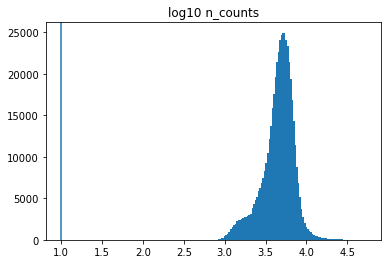

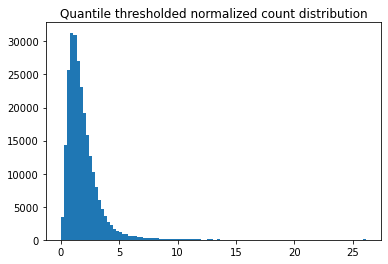

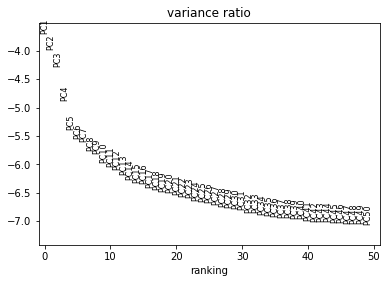

2023-10-06 20:58:44,844 - harmonypy - INFO - Iteration 1 of 20
2023-10-06 21:15:14,626 - harmonypy - INFO - Iteration 2 of 20
2023-10-06 21:32:19,877 - harmonypy - INFO - Iteration 3 of 20
2023-10-06 21:45:47,927 - harmonypy - INFO - Iteration 4 of 20
2023-10-06 22:01:33,030 - harmonypy - INFO - Converged after 4 iterations
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [37]:
adata = sc.read(paths['Original'])

if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index

p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [38]:
paths['RNA_Varnorm_Harmony']

'../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [39]:
paths['RNA_and_ADT_TP10K']

'../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA_and_ADT.TP10K.h5ad'

In [48]:
adata_tp10k.X

<500089x17223 sparse matrix of type '<class 'numpy.float32'>'
	with 738298741 stored elements in COOrdinate format>

In [49]:
adata_tp10k.X = adata_tp10k.X.tocsr()

In [52]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['RNA_and_ADT_TP10K'], adata_tp10k)

Only considering the two last: ['.TP10K', '.h5ad'].
Only considering the two last: ['.TP10K', '.h5ad'].


In [53]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

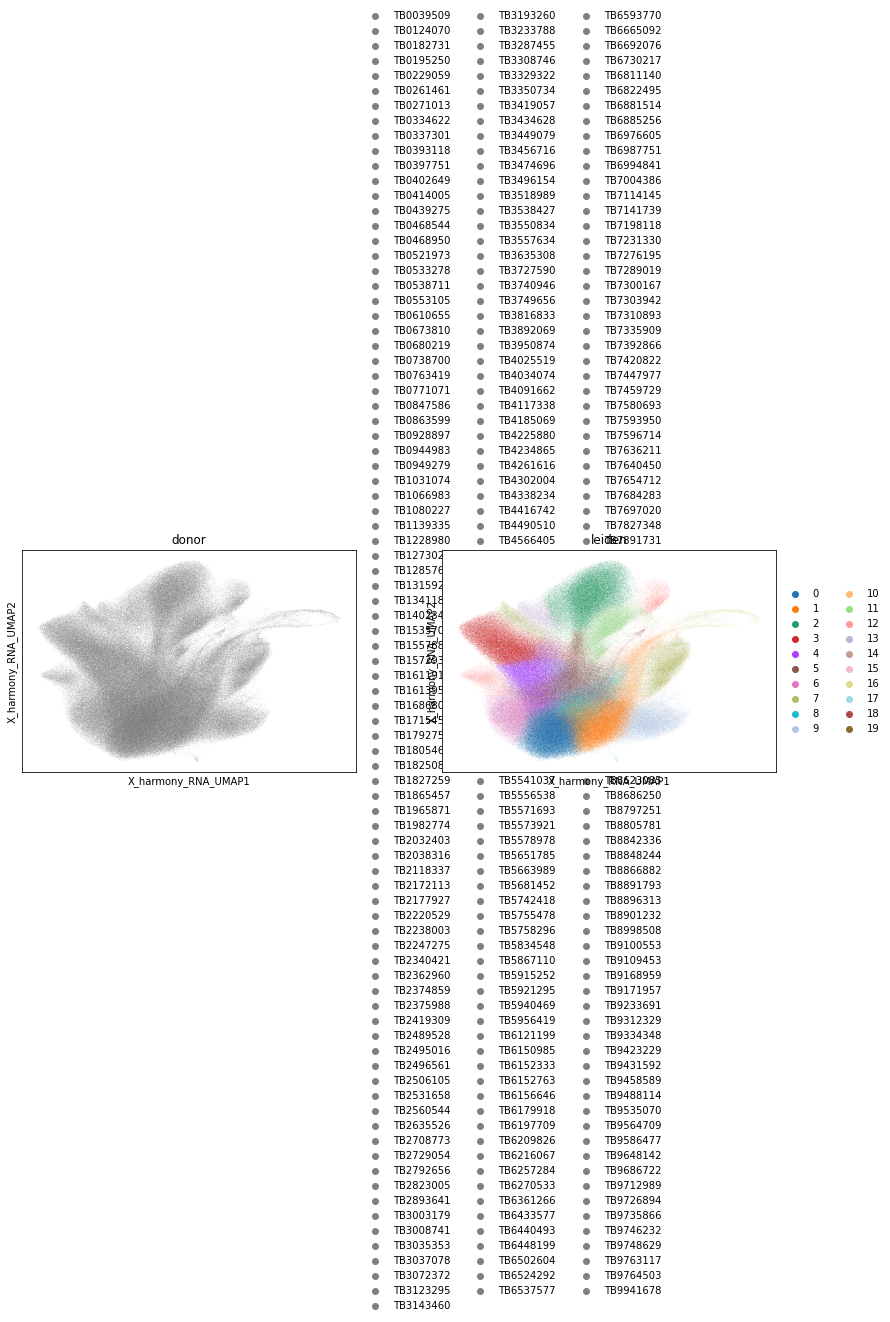

In [55]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [56]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [7]:
# Filt raw data to cells used for cnmf only 
adata_RNA_c = sc.read(paths['RNA_Varnorm_Harmony'])
adata_filt = adata[adata_RNA_c.obs.index, ]

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [8]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((500089, 33569), (500089, 2000), (500089, 33569))

In [9]:
paths['Raw_Filt_For_cNMF']

'../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006FiltForcNMF.h5ad'

In [10]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

Only considering the two last: ['.20231006FiltForcNMF', '.h5ad'].
Only considering the two last: ['.20231006FiltForcNMF', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


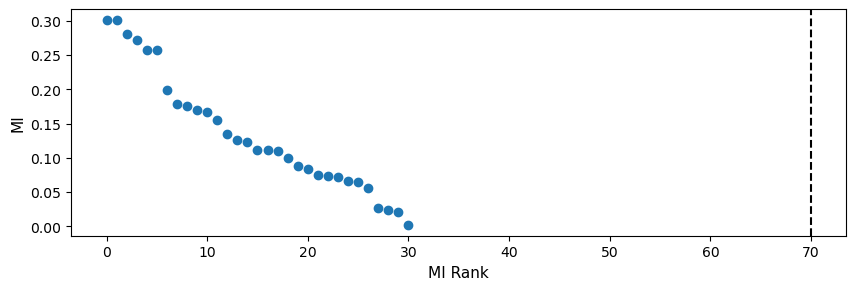

In [57]:
adata_ADT = p.select_features_MI(adata_ADT, adata_RNA_c.obs['leiden'], n_top_features = params['n_top_adt_genes'], max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [58]:
paths

{'Original': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006metadata.tsv',
 'ADT_MI_Rank': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA_and_ADT.HVGlist.tsv',
 'RNA_and_ADT_Varnorm_Harmony_WNN': '../../../Data/PerDataset/TBRU/tbru_exp

In [59]:
adata_ADT.var.to_csv(paths['ADT_MI_Rank'], sep='\t')

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


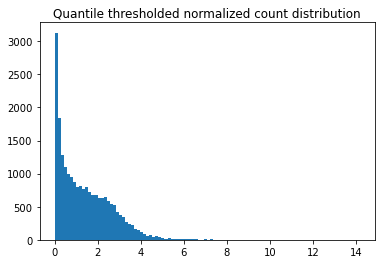

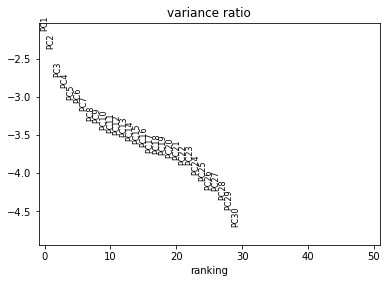

2023-10-07 13:04:38,576 - harmonypy - INFO - Iteration 1 of 20
2023-10-07 13:18:32,862 - harmonypy - INFO - Iteration 2 of 20
2023-10-07 13:31:18,473 - harmonypy - INFO - Iteration 3 of 20
2023-10-07 13:52:22,193 - harmonypy - INFO - Iteration 4 of 20
2023-10-07 14:02:24,592 - harmonypy - INFO - Iteration 5 of 20
2023-10-07 14:17:36,609 - harmonypy - INFO - Iteration 6 of 20
2023-10-07 14:25:19,856 - harmonypy - INFO - Iteration 7 of 20
2023-10-07 14:32:06,567 - harmonypy - INFO - Iteration 8 of 20
2023-10-07 14:38:36,429 - harmonypy - INFO - Iteration 9 of 20
2023-10-07 14:51:12,391 - harmonypy - INFO - Converged after 9 iterations


In [60]:
adata_ADT_c, adata_ADT_hvgs = p.normalize_batchcorrect(adata_ADT, normalize_librarysize=False, harmony_vars=params['harmony_vars'], n_top_genes = None, max_scaled_thresh = params['max_scaled_thresh'],
                               quantile_thresh = params['quantile_thresh'], makeplots=True)

In [61]:
sc.pp.neighbors(adata_ADT_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_adt_pcs'], use_rep='X_pca_harmony')

In [62]:
adata_ADT_c

AnnData object with n_obs × n_vars = 500089 × 31
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'n_counts'
    var: 'Name', 'Name_ADT_Fixed', 'Gene_ADT_Fixed', 'Clone_ADT_Fixed', 'feature_types', 'features_renamed', 'mean', 'std', 'MI', 'MI_Rank', 'MI_diff', 'highly_variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony'
    obsp: 'distances', 'connectivities'

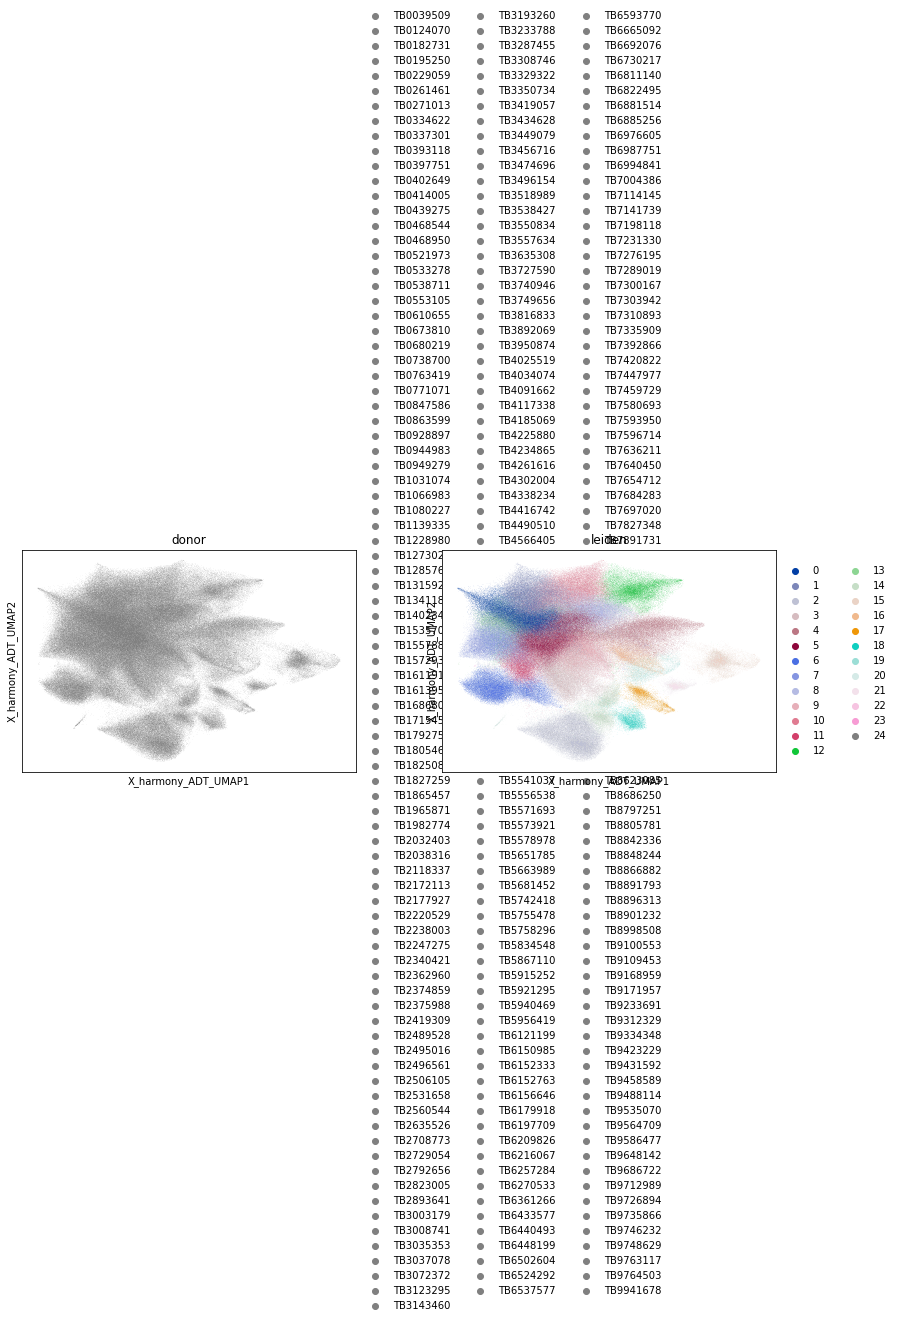

In [65]:
sc.tl.umap(adata_ADT_c)
adata_ADT_c.obsm['X_harmony_ADT_UMAP'] = adata_ADT_c.obsm['X_umap']
sc.tl.leiden(adata_ADT_c, resolution=1)
sc.pl.embedding(adata_ADT_c, basis='X_harmony_ADT_UMAP', color= params['harmony_vars'] + ['leiden'])

In [68]:
sc.write(paths['ADT_Varnom_Harmony'], adata_ADT_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/pynndescent/pynndescent_.

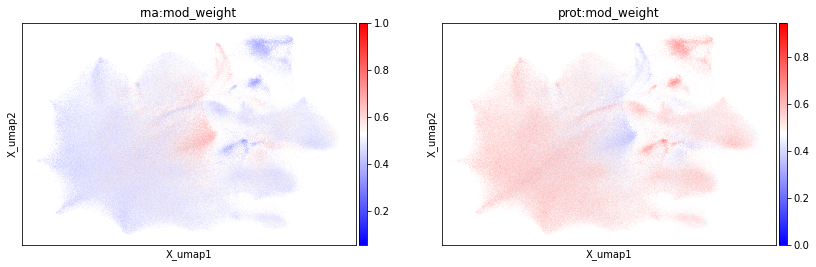

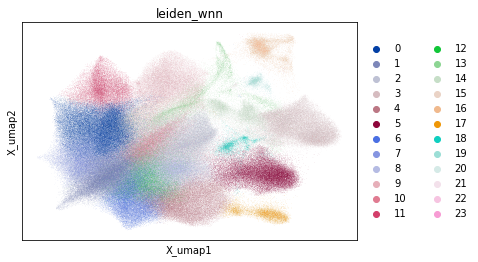

In [69]:
mdata = mu.MuData({'rna': adata_RNA_c, 'prot': adata_ADT_c})
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='bwr')
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')
mu.pl.umap(mdata, color=['leiden_wnn'])

In [70]:
mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
mdata['prot'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

In [74]:
mu.write(paths['RNA_and_ADT_Varnorm_Harmony_WNN'], mdata)

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


In [75]:
paths['WNN_UMAP']

'../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'

In [76]:
umap = pd.DataFrame(mdata.obsm['X_wnn_umap'], index=mdata.obs.index, columns=['WNN_UMAP_1', 'WNN_UMAP_2'])

In [78]:
umap.to_csv(paths['WNN_UMAP'], sep='\t')

In [79]:
merge_var = pd.concat([adata_RNA_c.var, adata_ADT_c.var], axis=0)            
adata_c = sc.AnnData(np.concatenate((adata_RNA_c.X, adata_ADT_c.X), axis=1), obs=adata_RNA_c.obs, var=merge_var)

In [80]:
adata_c.obsm['X_pca_rna'] = adata_RNA_c.obsm['X_pca']
adata_c.obsm['X_pca_rna_harmony'] = adata_RNA_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_rna'] = adata_RNA_c.obsm['X_harmony_RNA_UMAP']

adata_c.obsm['X_pca_adt'] = adata_ADT_c.obsm['X_pca']
adata_c.obsm['X_pca_adt_harmony'] = adata_ADT_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_adt'] = adata_ADT_c.obsm['X_harmony_ADT_UMAP']
adata_c.obsm['X_umap_WNN'] = mdata.obsm['X_wnn_umap']

In [81]:
paths['RNA_and_ADT_Varnorm_Harmony']

'../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [82]:
sc.write(paths['RNA_and_ADT_Varnorm_Harmony'], adata_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
